## Домашнее задание 2. Классификация изображений. Сверточные нейронные сети.
### О задании

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=0).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

## №1
Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 

In [14]:
import numpy as np
import torch
import torchvision as tv
from torchvision import transforms as T
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
from copy import deepcopy

### Подготовка данных

In [15]:
# Строка для работы в Colab
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2022-02-01 13:33:11--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2022-02-01 13:33:11--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaec3ff128cf6ef11eda4873a81.dl.dropboxusercontent.com/cd/0/get/Be5rDQNtj9KyVsP4vDorDSxK9VYG607wC7o5HMFLOWqgbcoYBB1OM43uV9f3K_B12c8wXPBYun04-pn7-JBAGwqSMaNJsdiLQyCkl9V82MXO0ss_2_j2719DfCZQHJqUXC07AF1ygB55zIoljWtlZW2a/file?dl=1# [following]
--2022-02-01 13:33:11--  https://ucaec3ff128cf6ef11eda4873a81.dl.dropboxusercontent.com/cd/0/get/Be5rDQNtj9KyVsP4vDorDSxK9VYG607wC7o5HMFLOWqgbcoYBB1OM43uV9f3K_B12c8wXPBYun04-pn7-JBAGwqSMa

In [16]:
train_transform = T.Compose([
    T.RandomCrop(64, padding=2),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # seminars 2-3 193
    # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # seminars 2-3 193
    # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = tv.datasets.ImageFolder("./dataset/dataset/train", transform=train_transform)
val_set = tv.datasets.ImageFolder("./dataset/dataset/val", transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, pin_memory=True, num_workers=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, pin_memory=True, num_workers=2)

In [17]:
# Простая проверка данных на вшивость (тип элементов сета, размерность элемента сета, тип таргета элемента)
assert isinstance(train_set[0], tuple), 'Type elem sets is not a tuple '
assert len(train_set[0]) == 2, 'Len element is not 2 (X, y)'
assert isinstance(train_set[1][1], int), 'Target is not type int'
print("Test checks passed")

Test checks passed


In [18]:
train_set[2136][0][0]

tensor([[-0.9364, -0.9946, -0.7232,  ..., -1.1690, -2.4291, -2.4291],
        [-0.9752, -0.8589, -0.5875,  ..., -1.3241, -2.4291, -2.4291],
        [-0.9364, -0.8589, -0.7232,  ..., -1.5955, -2.4291, -2.4291],
        ...,
        [-1.0140, -1.4211, -0.8395,  ..., -0.8977, -2.4291, -2.4291],
        [-1.0721, -0.8395, -0.1998,  ..., -0.6457, -2.4291, -2.4291],
        [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]])

78


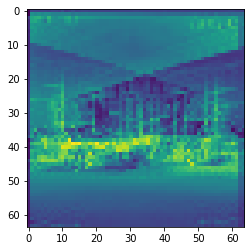

In [19]:
img_num = 39001
plt.imshow(np.array(train_set[img_num][0][0])+np.array(train_set[img_num][0][1])+np.array(train_set[img_num][0][2]))
print(train_set[img_num][1]) # Значение таргета картинки, хз что это за класс, видимо авто
# T.ToPILImage()(train_set[img_num][0])

### Вспомогательные функции, реализация модели

In [20]:
def SetRandomSeed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [21]:
class ConvNet(nn.Module): # seminars 2-3 193
    def __init__(self, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
        )
        
        self.head = nn.Sequential(
            nn.Linear(64, 100), # первый скрытый слой делает линейное преобразование
            nn.ReLU(), # активация Релю первого слоя
            nn.Linear(100, 200),
        )
        
    def forward(self, images):
        features = self.features(images)
        features = features.mean(dim=(2, 3))
        logits = self.head(features)
        return logits

In [22]:
class Coach(object):
    """
    Класс объекта тренера (коучер), который обучает модель нейросетки
    """
    def __init__(self, model, optimizer, criterion,
                 device, scheduler=None, num_epochs=1):
        
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.scheduler = scheduler
        
        self.init_epoch = 1
        self.num_epochs = num_epochs
        self.epoch = self.init_epoch
        
        self.best_accuracy = 0
        self.best_model = deepcopy(self.model)

        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
        
    def run(self, train_loader, test_loader):
        
        for epoch in range(self.init_epoch, self.num_epochs + 1):

            self.epoch = epoch
            self.__CalcPredict__(train_loader)
            self.__CalcPredict__(test_loader, train=False)
            self.plot()
            print(f'Best test accuracy = {max(self.test_accuracies)}; оценка {np.clip(10 * max(self.test_accuracies) / 0.44, 0, 10):.2f} баллов')
            print(f'Actual test accuracy = {self.test_accuracies[-1]}; оценка {np.clip(10 * self.test_accuracies[-1] / 0.44, 0, 10):.2f} баллов')
            if self.scheduler is not None:
                self.scheduler.step()    

    def plot(self):
        clear_output()
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        self.__PlotAxes__(ax1, self.train_losses, self.test_losses, 'Losses')
        self.__PlotAxes__(ax2, self.train_accuracies, self.test_accuracies, 'Accuracy')
        plt.show()
    
    def reset(self):
        self.train_losses = []
        self.test_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
    
    def __CalcPredict__(self, loader, train=True):
        
        name = 'Training' if train else 'Testing'
        running_loss, running_accuracy = 0., 0.
        
        true_labels = torch.Tensor().to(self.device)
        predicted = torch.Tensor().to(self.device)

        if train:
          self.model.train()
        else:
          self.model.eval()

        for images, labels in tqdm(loader, desc=name + f' {self.epoch}/{self.num_epochs}'):

            images = images.to(self.device)
            labels = labels.to(self.device)
            true_labels = torch.cat((labels, true_labels))

            outputs, loss, accuracy = self.__TrainPredict__(images, labels) if train else self.__TestPredict__(images, labels)

            predicted = torch.cat((outputs, predicted))

            running_loss += loss.item() * images.shape[0]
            running_accuracy += accuracy

        predict_labels = torch.argmax(predicted, dim=1)
        loss = running_loss / len(loader.dataset)
        accuracy = running_accuracy / len(loader.dataset)
        
        if train:
            self.train_losses += [loss]
            self.train_accuracies += [accuracy]
        else:
            self.test_losses += [loss]
            self.test_accuracies += [accuracy]

            if self.test_accuracies[-1] > self.best_accuracy:
                self.best_model = deepcopy(self.model) 

        return loss, predict_labels, true_labels
    
    def __TrainPredict__(self, data, labels):
        self.optimizer.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, labels)
        loss.backward()
        self.optimizer.step()
        accuracy = (outputs.argmax(dim=-1) == labels).sum().item()
        return outputs, loss, accuracy

    def __TestPredict__(self, data, labels):
        with torch.no_grad():
            outputs = self.model(data)
            loss = self.criterion(outputs, labels)  
            accuracy = (outputs.argmax(dim=-1) == labels).sum().item()    
        return outputs, loss, accuracy
            
    def __PlotAxes__(self, ax, train, test, name):
        ax.plot(range(1, self.epoch + 1), train, label='Train')
        ax.plot(range(1, self.epoch + 1), test, label='Test')
        ax.set_title(name + f' over epochs {self.epoch}')
        ax.set_ylabel(name)
        ax.set_xlabel('epoch')
        ax.legend()
        ax.grid()

### Обучение модели, запуски экспериментов

In [23]:
seed = SetRandomSeed(555)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = ConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = None
num_epochs = 25
Trainer = Coach(model, optimizer, criterion, device, num_epochs=num_epochs)

#### Проверка правильности написанного кода

In [ ]:
all_losses, predicted_labels, true_labels = Trainer.__CalcPredict__(val_loader)
assert len(predicted_labels) == len(val_set)
accuracy = accuracy_score(predicted_labels.cpu(), true_labels.cpu())
print("Test run passed")

Training 1/25:   0%|          | 0/157 [00:00<?, ?it/s]

Test run passed


### Эксперимент 1: два скрытых слоя по 256 нейронов

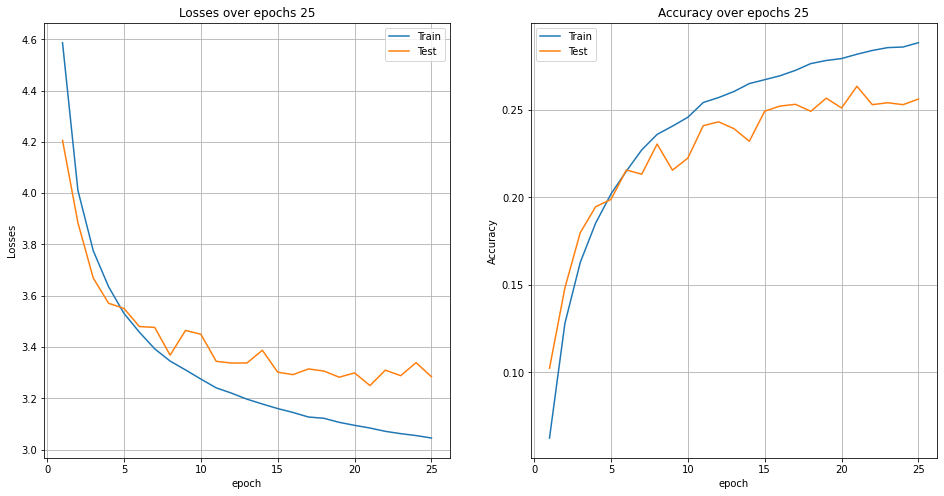

Best test accuracy = 0.2634; 



In [ ]:
Trainer.run(train_loader, val_loader) 

In [ ]:
accuracy = max(Trainer.test_accuracies)
print(f'Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов')

Оценка за это задание составит 5.99 баллов


### Эксперимент 2: 3 скрытых слоя: 64->128->256->256->200

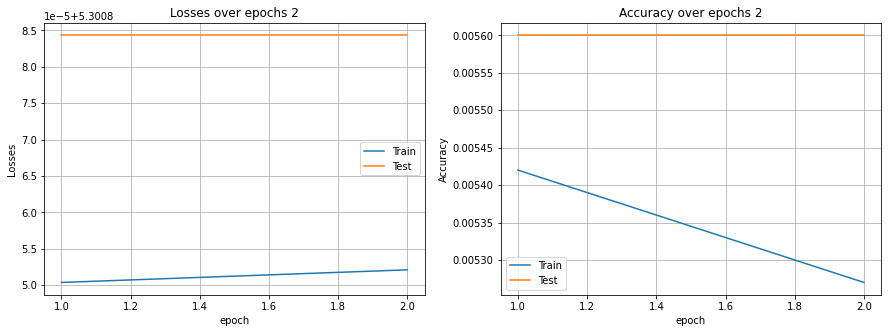

Best test accuracy = 0.0056; оценка 0.13 баллов
Actual test accuracy = 0.0056; оценка 0.13 баллов


Training 3/25:   0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
model = ConvNet().to(device)
Trainer = Coach(model, optimizer, criterion, device, num_epochs=num_epochs)
Trainer.run(train_loader, val_loader) 

### Эксперимент 3: меняем модель

In [ ]:
class ConvNetVer2(ConvNet):
    def __init__(self, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
        )
        
        self.head = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 200)
        )

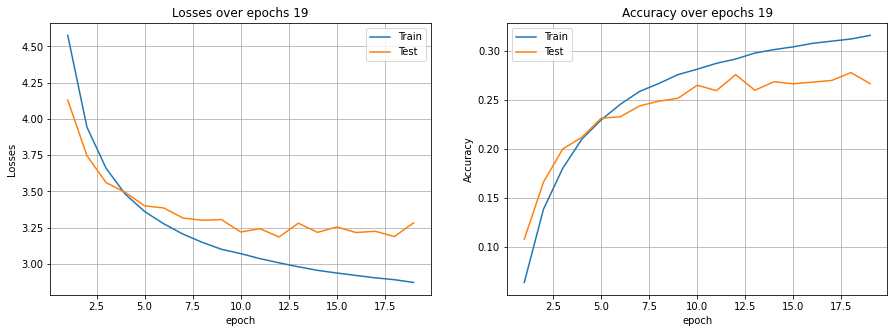

Best test accuracy = 0.2782; оценка 6.32 баллов
Actual test accuracy = 0.2668; оценка 6.06 баллов


Training 20/25:   0%|          | 0/1563 [00:00<?, ?it/s]

In [ ]:
model = ConvNetVer2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
Trainer = Coach(model, optimizer, criterion, device, num_epochs=num_epochs)
Trainer.run(train_loader, val_loader) 

### Эксперимент 4: снова меняем модель

In [29]:
class ConvNetVer3(ConvNet):
    def __init__(self, in_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 3, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
        )
        
        self.head = nn.Sequential(
            nn.Linear(256, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
        )

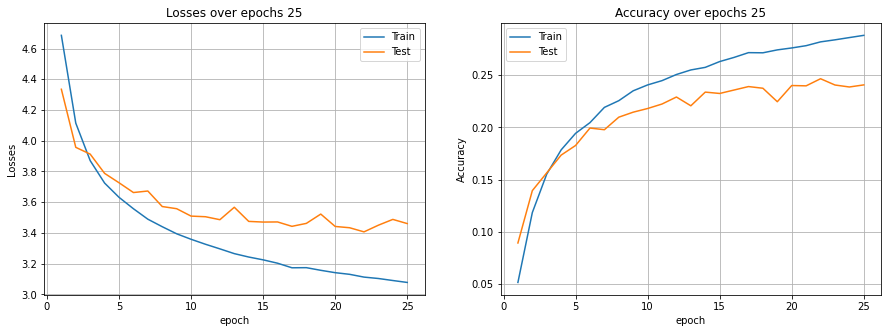

Best test accuracy = 0.2466; оценка 5.60 баллов
Actual test accuracy = 0.2407; оценка 5.47 баллов


In [ ]:
model = ConvNetVer3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
Trainer = Coach(model, optimizer, criterion, device, num_epochs=num_epochs)
Trainer.run(train_loader, val_loader) 

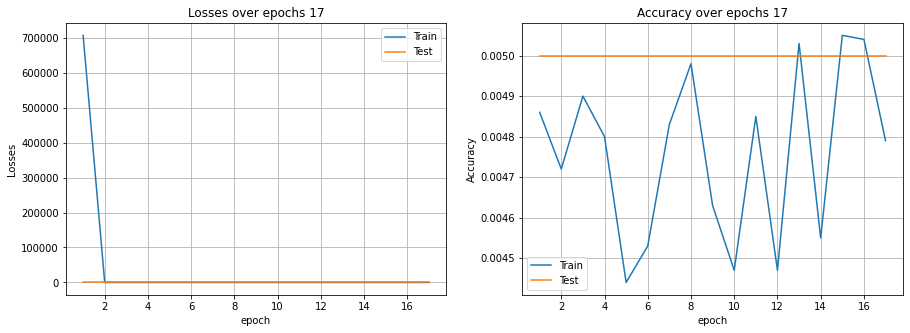

Best test accuracy = 0.005; оценка 0.11 баллов
Actual test accuracy = 0.005; оценка 0.11 баллов


Training 18/25:   0%|          | 0/1563 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [30]:
model = ConvNetVer3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
Trainer = Coach(model, optimizer, criterion, device, num_epochs=num_epochs)
Trainer.run(train_loader, val_loader) 

In [ ]:
Trainer.train_losses, Trainer.test_losses

([], [])

### Проверка полученной accuracy

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, реализуйте и запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.